In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [2]:
from currency_converter import CurrencyConverter, RateNotFoundError
from datetime import datetime, timedelta
from collections import defaultdict
from typing import Optional

from scikit_posthocs import posthoc_dunn
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

from analysis.helper import (postgres_data, define_game, assign_region,
                             format_genre, define_currency)
from analysis.helper import PLATFORMS, COLORS, GENRES

import warnings
warnings.filterwarnings('ignore')


ALPHA = .05

## **Activity Analysis for 2024**

> **Note:** The data reflects only `activity points`. This means that if a player earns an achievement, it indicates that they are actively playing the game.  
> However, the absence of achievements does not necessarily mean the game is **not being played**  

<i>Example:</i> CS2 has only one achievement, yet millions play it daily

> **Note:** **Before running** the next cell, you **need to execute** the file `get_activites.py`, which will collect and aggregate the necessary data from the database.  
This file will take a considerable amount of time to run, **approximately 2 hours**  

***I cannot upload the CSV file to GitHub because it is too large***

In [3]:
# Cell execution time ~18m 33.6s

# User activity history across different platforms for the year 2024
activities = {}
for platform in PLATFORMS:
    activities[platform] = postgres_data(platform, 'history', year=2024)

activities[PLATFORMS[0]].head(3)

,playerid,achievementid,date_acquired
0,76561198003275888,365360_Moneymaker,2024-03-24 16:13:19
1,76561198003275888,365360_AKnightsTale,2024-03-19 06:21:25
2,76561198003275888,365360_Bullseye,2024-03-20 04:32:50


In [4]:
for platform in PLATFORMS:
    activities[platform]['gameid'] = activities[platform].achievementid.apply(define_game)

    # Extracting YYYY-MM-DD, YYYY-MM, MM, WD, HH from the achievement's timestamp
    activities[platform]['date'] = activities[platform].date_acquired.dt.date
    activities[platform]['year_month'] = activities[platform].date_acquired.dt.to_period('M')
    activities[platform]['month'] = activities[platform].date_acquired.dt.month
    activities[platform]['weekday'] = activities[platform].date.apply(datetime.isoweekday)
    activities[platform]['hour'] = activities[platform].date_acquired.dt.hour.astype('int8')

Use the preprocessed data from the `games` table, obtained in the `overview.ipynb` notebook,  
and remove irrelevant games from the `history` table

In [5]:
gameids = {}
for platform in PLATFORMS:
    gameids[platform] = set(pd.read_csv(f'resources/games_{platform}.csv').gameid)

    activities[platform] = activities[platform].query('gameid in @gameids[@platform]')

activities[PLATFORMS[0]].head(3)

,playerid,achievementid,date_acquired,gameid,date,year_month,month,weekday,hour
0,76561198003275888,365360_Moneymaker,2024-03-24 16:13:19,365360,2024-03-24,2024-03,3,7,16
1,76561198003275888,365360_AKnightsTale,2024-03-19 06:21:25,365360,2024-03-19,2024-03,3,2,6
2,76561198003275888,365360_Bullseye,2024-03-20 04:32:50,365360,2024-03-20,2024-03,3,3,4


### **Analysis of the Hourly, Weekly, Monthly Activity**

In [6]:
def _activity(dataframe: pd.DataFrame, period: str) -> pd.DataFrame:
    """
    This function filters the dataframe based on the specified period, counts the occurrences of each unique value,  
    and returns a new dataframe.

    Args:
        **dataframe (pd.DataFrame)** - The input dataframe containing activity data.
        **period (str)** - The name of the column in the dataframe representing the period to analyze.

    Returns:
        **pd.DataFrame** - A dataframe containing the unique values from the specified period and their respective counts.
    """
    return (
        dataframe[period]
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )

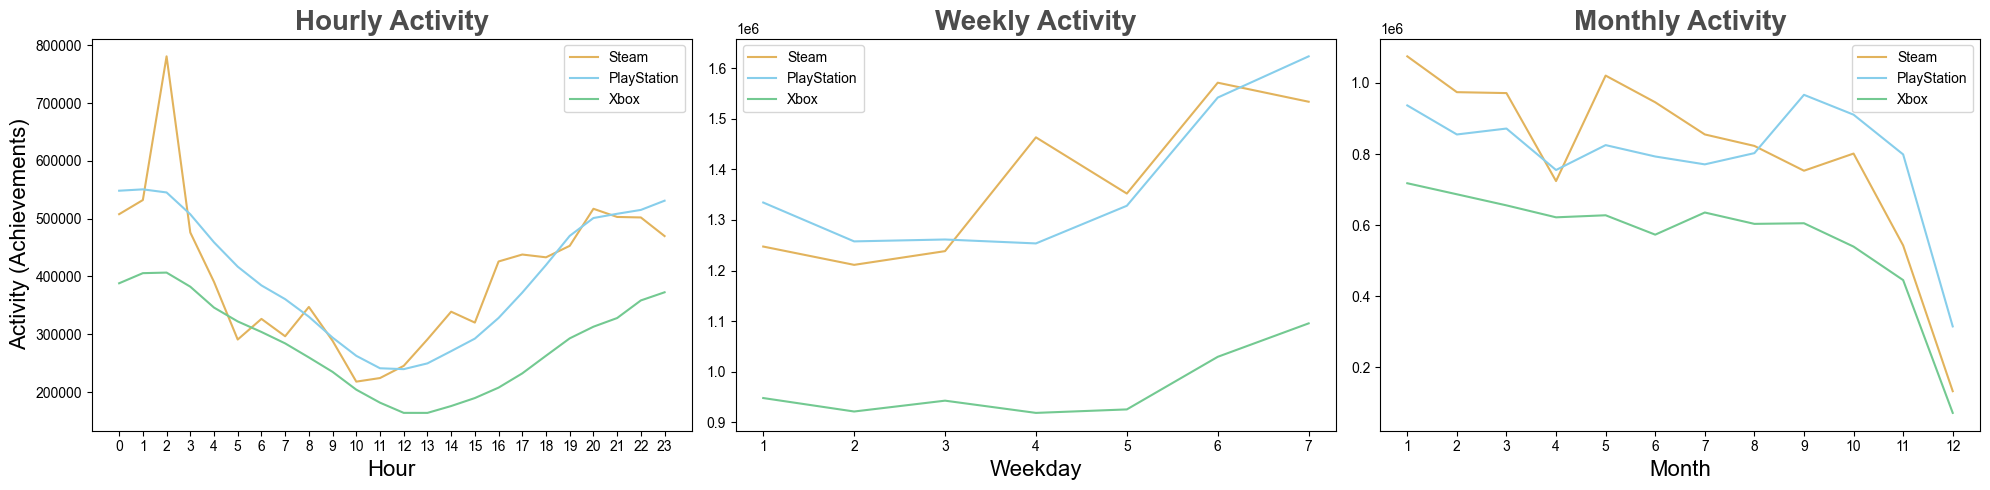

In [7]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    hourly = _activity(activities[platform], 'hour')
    weekdays = _activity(activities[platform], 'weekday')
    monthly = _activity(activities[platform], 'month')

    sns.lineplot(x=hourly.hour, y=hourly.quantity, color=color, ax=axes[0], label=label)
    sns.lineplot(x=weekdays.weekday, y=weekdays.quantity, color=color, ax=axes[1], label=label)
    sns.lineplot(x=monthly.month, y=monthly.quantity, color=color, ax=axes[2], label=label)
    
axes[0].set_xlabel('Hour', fontsize=16)
axes[0].set_ylabel('Activity (Achievements)', fontsize=16)
axes[0].set_xticks(hourly.hour.unique())
axes[0].set_title('Hourly Activity', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[0].legend()

axes[1].set_xlabel('Weekday', fontsize=16)
axes[1].set_ylabel('')
axes[1].set_title('Weekly Activity', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[1].legend()

axes[2].set_xlabel('Month', fontsize=16)
axes[2].set_ylabel('')
axes[2].set_xticks(monthly.month.unique())
axes[2].set_title('Monthly Activity', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[2].legend()

plt.tight_layout()

> **Note:** The **significance of the last two months** in the `Monthly Activity` graph should be disregarded.  
> This sharp decline is due to the data collection method (see **documentation**). *Such a pattern is not observed in previous years*

Each graph shows a general *'logical'* trend for `PlayStation` and `Xbox` platforms, while `Steam` exhibits some inflated and noisy values (maximum at **2AM**, and spike on **Thursday**)

#### **Anomaly Detection on the Steam Platform**

Investigating **Thursday** and **2AM** separately to understand the cause of the sudden spike

In [8]:
# Calculating the number of achievements earned every Thursday throughout the entire year
activities[PLATFORMS[0]].query('weekday == 4').date.value_counts().describe()

count        50.000000
mean      29266.620000
std       46500.125112
min        3184.000000
25%       15671.250000
50%       19521.000000
75%       25458.250000
max      340039.000000
Name: count, dtype: float64

The **maximum value** deviates significantly from the average, **even considering $2\sigma$**  
Let's examine the data separately by players to see who and how many achievements were earned on **Thursdays**

In [9]:
activities[PLATFORMS[0]].query('weekday == 4').playerid.value_counts()

playerid
76561199014028512    319174
76561199643317571     50000
76561198837504437     24424
76561198854461127     23867
76561199421659790     20221
                      ...  
76561198042797571         1
76561198873483663         1
76561198391791168         1
76561198872555163         1
76561199246548320         1
Name: count, Length: 28308, dtype: int64

Examine the activity of the player `76561199014028512` separately

In [10]:
activities[PLATFORMS[0]].query('playerid == "76561199014028512"')

,playerid,achievementid,date_acquired,gameid,date,year_month,month,weekday,hour
8071422,76561199014028512,38600_ACH_26,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8071439,76561199014028512,38600_ACH_27,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8071527,76561199014028512,38600_ACH_28,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8071679,76561199014028512,38600_ACH_29,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
8071743,76561199014028512,38600_ACH_30,2024-05-08 20:09:59,38600,2024-05-08,2024-05,5,3,20
...,...,...,...,...,...,...,...,...,...
8445250,76561199014028512,2961330_Achievement_23,2024-07-05 08:39:00,2961330,2024-07-05,2024-07,7,5,8
8445251,76561199014028512,2961330_Achievement_24,2024-07-05 08:34:21,2961330,2024-07-05,2024-07,7,5,8
8445252,76561199014028512,2961330_Achievement_25,2024-07-05 08:39:20,2961330,2024-07-05,2024-07,7,5,8
8445723,76561199014028512,2961330_Achievement_28,2024-07-05 08:39:39,2961330,2024-07-05,2024-07,7,5,8


*It is important to know the following facts about the platforms:*
* In `Steam`, **achievements can be hacked**, which leads to increased playability, activity, and noise in the data
* On `PlayStation` and `Xbox` platforms, such issues do not occur. However, **save transfers** are possible,  
*Example: from PS4 to PS5, which can result in achievements being unlocked immediately on the new platform*

> As we can observe, some different achievements were earned at the exact same time, down to the second, which is highly unlikely to be possible

#### **Detection of Achievement Manipulation**

**General idea:** Calculate the **delta** between the acquisition of consecutive achievements,  
and if the percentage of identical deltas exceeds **65%** of the total achievements for a game, remove such data from the sample

In [11]:
# Total number of achievements in each game
achievements_df = {}
for platform in PLATFORMS:
    achievements_df[platform] = (
        postgres_data(platform, 'achievements')
        .query('gameid in @gameids[@platform]')
        .gameid
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'total'})
    )

achievements_df[PLATFORMS[0]].head(3)

,gameid,total
0,664290,10979
1,573060,9821
2,640310,5394


#### **Algorithm detection**

In [12]:
# A dictionary where the keys are platform names,
# and the values are processed data from the `history` table (free from manipulations)
clear_activities = {}
for platform in PLATFORMS:
    label = platform.capitalize().replace('s', 'S')

    # It is important to correctly determine the delta, so we sort the dataset by achievement acquisition date
    outliers = activities[platform][['playerid', 'gameid', 'date_acquired']].sort_values('date_acquired')

    outliers['prev_date_acquired'] = outliers.groupby(['playerid', 'gameid']).date_acquired.shift(1)

    # delta - number of minutes (float) between the previous and the next achievement earned
    outliers['delta'] = (outliers.date_acquired - outliers.prev_date_acquired).dt.total_seconds() / 60

    outliers_copy = (
        outliers.groupby(['playerid', 'gameid'])
        .delta
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'obtained'})
    )
    # Adding the total number of achievements to the table
    outliers_copy = outliers_copy.merge(achievements_df[platform], how='left')

    # Calculate the ratio of earned achievements to the total number of achievements
    outliers_copy['ratio'] = outliers_copy.obtained / outliers_copy.total * 100

    # Retain only games where the total number of achievements > 5,
    # since detecting manipulation with a smaller number is difficult.
    # For example, CS2 has only 1 achievement 'Play in CS2', resulting in a ratio of 100%
    # 6 achievements are sufficient to determine if manipulation has occurred.
    # Even if 3 achievements are earned in 1 second, the game's ratio would be 50% (such values are not excluded)
    outliers_copy = outliers_copy.query('total > 5')

    to_drop = outliers_copy.groupby(['playerid', 'gameid'])['ratio'].max()
    # 65% - empirical value. To improve detection, this parameter should be optimized
    to_drop = to_drop[to_drop >= 65].index

    outliers_copy = activities[platform].set_index(['playerid', 'gameid'])
    clear_activities[platform] = outliers_copy[~outliers_copy.index.isin(to_drop)].reset_index()

    print(f'{label}: Successfully detected {activities[platform].shape[0] - clear_activities[platform].shape[0]} events')

Steam: Successfully detected 4640207 events
PlayStation: Successfully detected 386381 events
Xbox: Successfully detected 22700 events


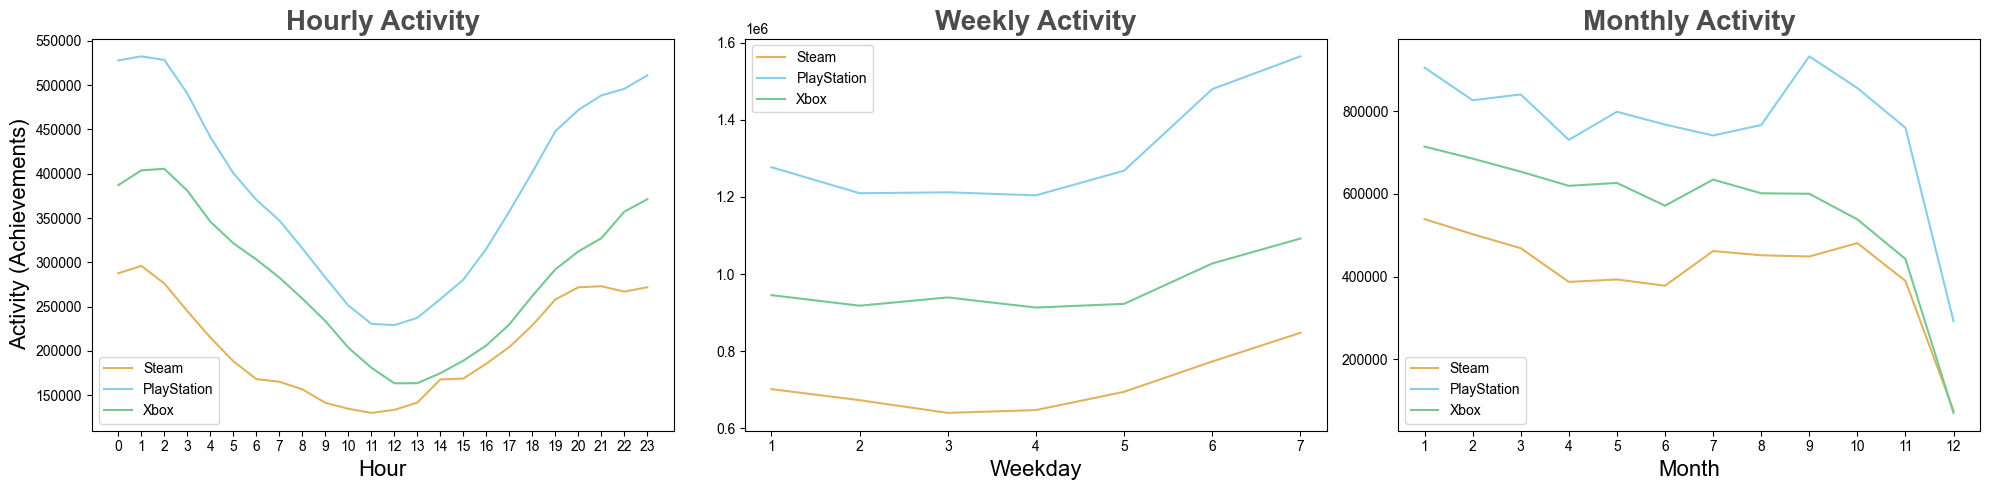

In [13]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    hourly = _activity(clear_activities[platform], 'hour')
    weekdays = _activity(clear_activities[platform], 'weekday')
    monthly = _activity(clear_activities[platform], 'month')

    sns.lineplot(x=hourly.hour, y=hourly.quantity, color=color, ax=axes[0], label=label)
    sns.lineplot(x=weekdays.weekday, y=weekdays.quantity, color=color, ax=axes[1], label=label)
    sns.lineplot(x=monthly.month, y=monthly.quantity, color=color, ax=axes[2], label=label)

axes[0].set_xlabel('Hour', fontsize=16)
axes[0].set_ylabel('Activity (Achievements)', fontsize=16)
axes[0].set_xticks(hourly.hour.unique())
axes[0].set_title('Hourly Activity', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[0].legend()

axes[1].set_xlabel('Weekday', fontsize=16)
axes[1].set_ylabel('')
axes[1].set_title('Weekly Activity', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[1].legend()

axes[2].set_xlabel('Month', fontsize=16)
axes[2].set_ylabel('')
axes[2].set_xticks(monthly.month.unique())
axes[2].set_title('Monthly Activity', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[2].legend()

plt.tight_layout()

**Conclusions:**
* Achievement **manipulation was successfully detected**, reducing noise in the data
* The line plots for the platforms are now 'separated' from each other. The **highest activity** is observed on the `PlayStation` platform
* **Weekdays are less active** compared to weekends
* Peak activity hours are in the evening and nighttime (**most players are active between 6PM and 2AM**)
* The `Monthly Activity` graph shows ambiguous trends

### **Metrics MAU, WAU**

In [14]:
# All weeks of the year
all_weeks = pd.date_range(start='2024-01-01', end='2024-12-31', freq='W-MON')
all_weeks_df = pd.DataFrame({'week': all_weeks})
# All months of the year
all_months_df = pd.DataFrame({'month': list(range(1, 13))})

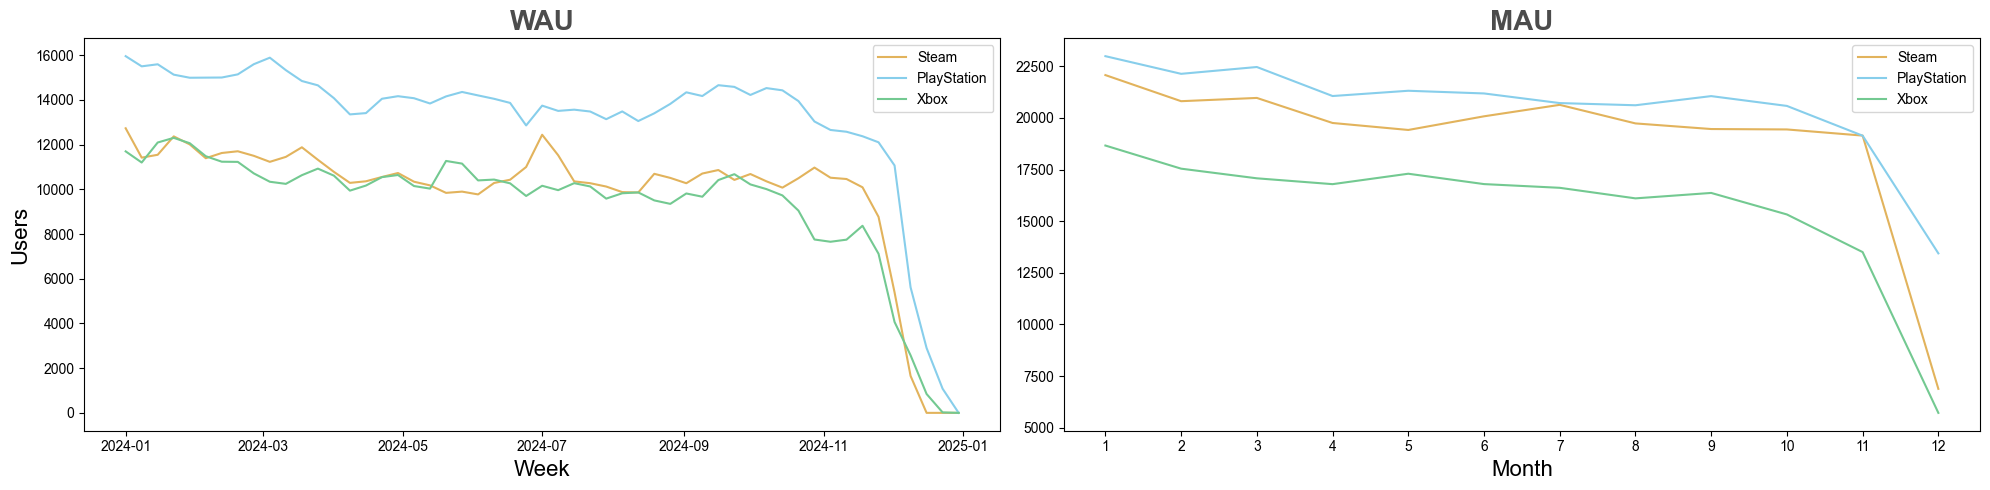

In [15]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    # Determine the start of the week for each activity
    clear_activities[platform]['week'] = clear_activities[platform].date_acquired - \
        pd.to_timedelta(clear_activities[platform].date_acquired.dt.dayofweek, unit='d')
    clear_activities[platform].week = clear_activities[platform].week.dt.date
    
    wau = clear_activities[platform].groupby('week', as_index=False).agg({'playerid': pd.Series.nunique})
    wau.week = pd.to_datetime(wau.week)
    wau = all_weeks_df.merge(wau, how='left').fillna(0).rename(columns={'playerid': 'users'})

    mau = clear_activities[platform].groupby('month', as_index=False).agg({'playerid': pd.Series.nunique})
    mau = all_months_df.merge(mau, how='left').fillna(0).rename(columns={'playerid': 'users'})

    sns.lineplot(x=wau.week, y=wau.users, color=color, ax=axes[0], label=label)
    sns.lineplot(x=mau.month, y=mau.users, color=color, ax=axes[1], label=label)
    
axes[0].set_xlabel('Week', fontsize=16)
axes[0].set_ylabel('Users', fontsize=16)
axes[0].set_title('WAU', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[0].legend()

axes[1].set_xlabel('Month', fontsize=16)
axes[1].set_ylabel('')
axes[1].set_xticks(mau.month.unique())
axes[1].set_title('MAU', fontsize=20, loc='center', weight='bold', alpha=.7)
axes[1].legend()

plt.tight_layout()

### **How often do users complete a game?**

> **Note:** **Completion** is defined as earning **100% of the achievements**

In [16]:
# Number of achievements earned by the user in each game
completely = {}
for platform in PLATFORMS:
    completely[platform] = (
        clear_activities[platform]
        .groupby(['playerid', 'gameid'], as_index=False)
        .agg({'achievementid': 'count'})
        .rename(columns={'achievementid': 'obtained'})
    )
    completely[platform] = completely[platform].merge(achievements_df[platform], how='left')
    
    completely[platform]['ratio'] = completely[platform].obtained / completely[platform].total * 100

completely[PLATFORMS[0]].head(3)

,playerid,gameid,obtained,total,ratio
0,76561197960270682,431240,3,83,3.614458
1,76561197960270682,684410,4,26,15.384615
2,76561197960270682,1497440,10,17,58.823529


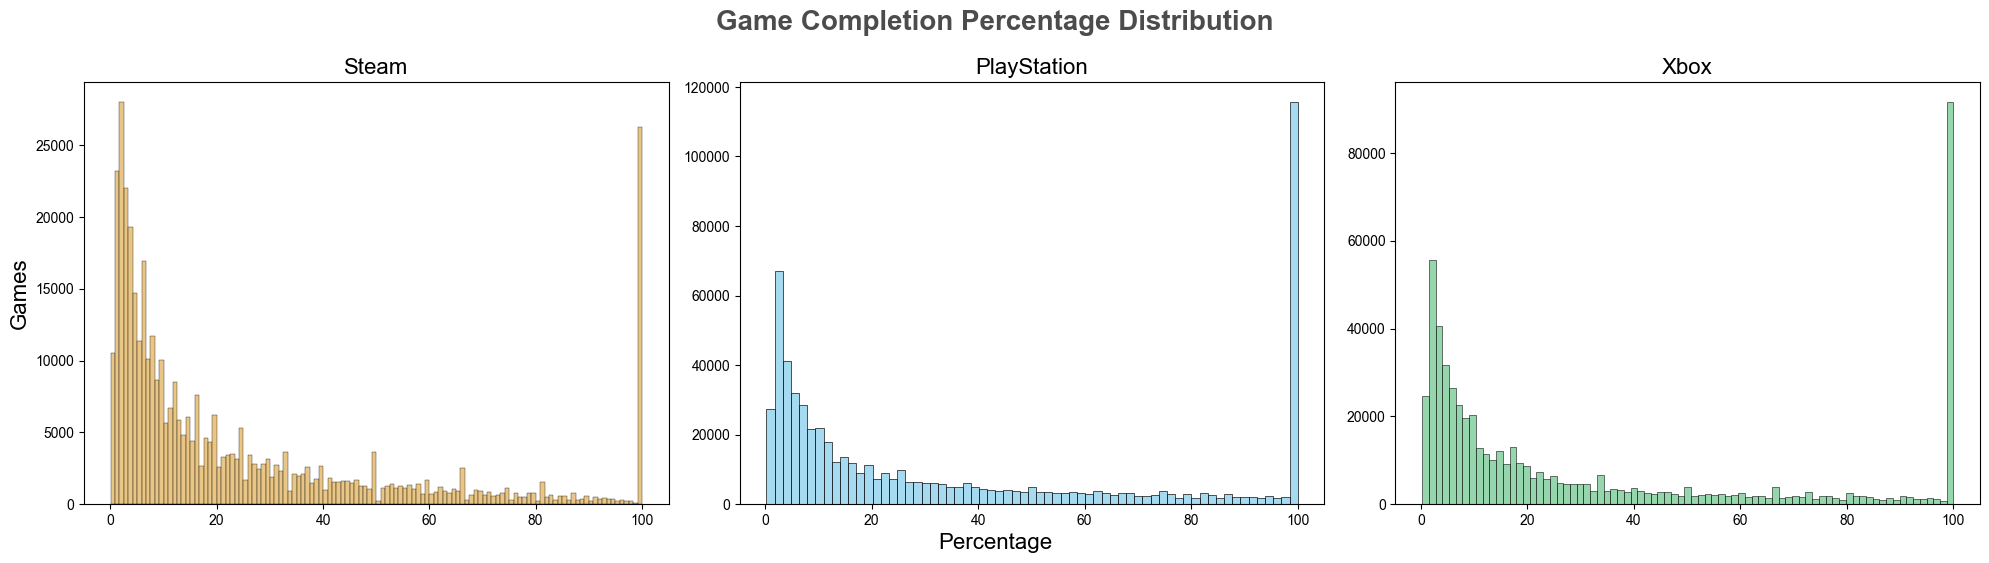

In [17]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    sns.histplot(completely[platform].ratio, ax=ax, color=color)

    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0].set_ylabel('Games', fontsize=16)

fig.text(.5, 0, 'Percentage',
         ha='center', va='center', fontsize=16)
fig.text(.5, 1.04, 'Game Completion Percentage Distribution',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

**Conclusions:**
* The graphs exhibit distributions **similar to a log-normal distribution**, but with a significant extreme right-hand value 
* The `history` table contains only user activities, which is why there is no 0% value on the graph
* Most users do not complete the games they start
* A **significant spike at 100%** suggests that if the completion percentage is sufficiently high, it **may motivate** the user to reach 100% completion
* This **trend** is consistent across **all platforms**

> To ensure more accurate interpretation of the data, we will filter out the extreme left and right values (0% and 100%)  
> Subsequently, we will analyze the ratio of these values

In [18]:
for platform in PLATFORMS:
    completely[platform] = completely[platform].query('ratio != 100')

Let's apply the natural logarithm to the data to achieve a distribution closer to normal

In [19]:
for platform in PLATFORMS:
    completely[platform]['log_ratio'] = np.log(completely[platform].ratio)

completely[PLATFORMS[0]].head(3)

,playerid,gameid,obtained,total,ratio,log_ratio
0,76561197960270682,431240,3,83,3.614458,1.284942
1,76561197960270682,684410,4,26,15.384615,2.733368
2,76561197960270682,1497440,10,17,58.823529,4.074542


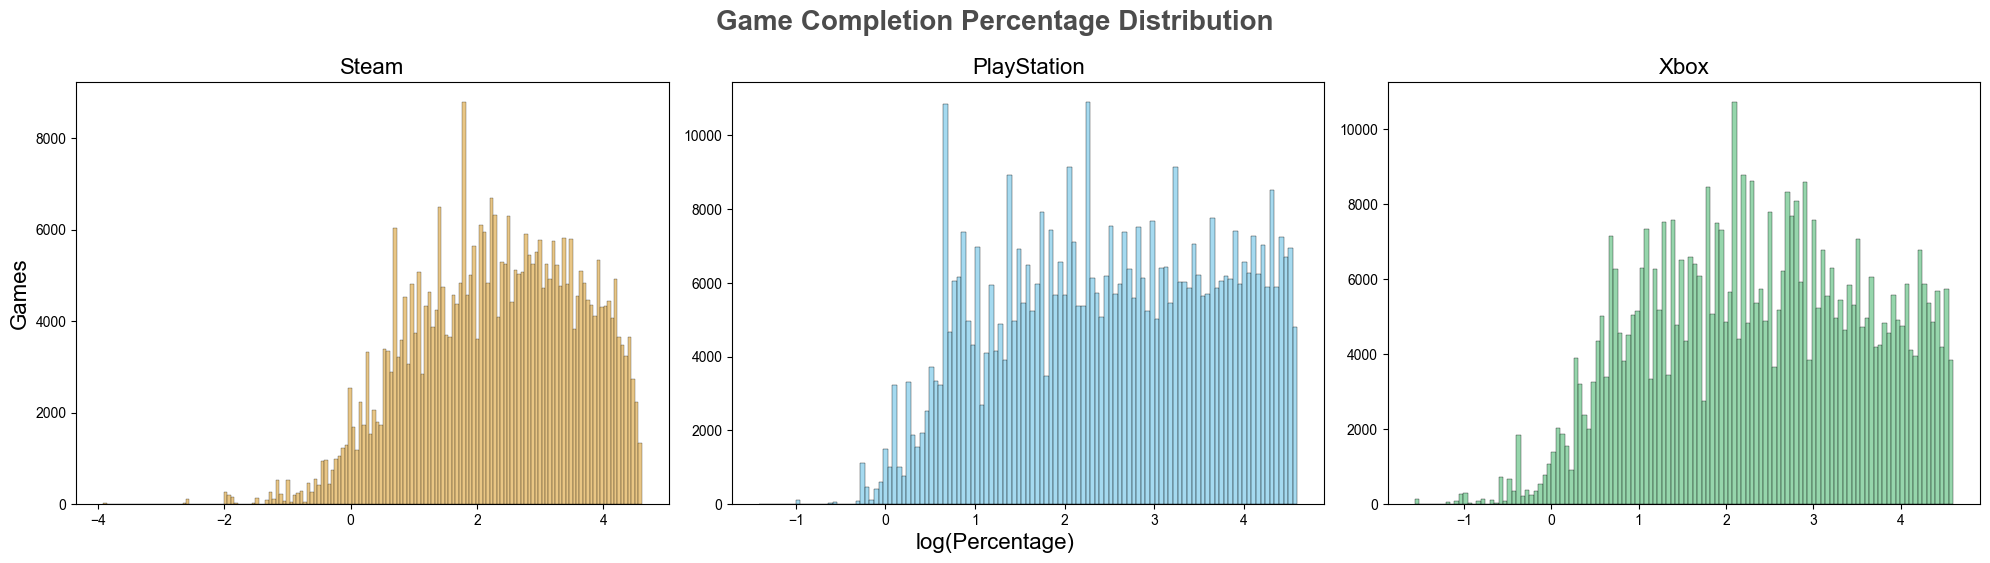

In [20]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    sns.histplot(completely[platform].log_ratio, ax=ax, color=color)

    ax.set_title(platform.capitalize().replace('s', 'S'), fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0].set_ylabel('Games', fontsize=16)

fig.text(.5, 0, 'log(Percentage)',
         ha='center', va='center', fontsize=16)
fig.text(.5, 1.04, 'Game Completion Percentage Distribution',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

Since all distributions deviate from normal, we will **use non-parametric methods**

> **Kruskal-Wallis Test and Dunn's Test with Holm's Correction**

In [21]:
samples = [completely[platform].ratio for platform in PLATFORMS]

statistic, pvalue = stats.kruskal(samples[0], samples[1], samples[2])
if pvalue < ALPHA:
    print(f'Kruskal-Wallis Test\n' \
          f'Statistical significance was found — There are differences between the groups\n' \
          f'Statistic: {statistic:.2f}  | Probability: {pvalue:.2f}  | Significance level: {ALPHA}')
else:
    print(f'Kruskal-Wallis Test\n' \
          f'No statistical significance was found — No differences were found between the groups\n' \
          f'Statistic: {statistic:.2f}  | Probability: {pvalue:.2f}  | Significance level: {ALPHA}')

Kruskal-Wallis Test
Statistical significance was found — There are differences between the groups
Statistic: 5287.92  | Probability: 0.00  | Significance level: 0.05


In [22]:
print('Dunn`s Test with Holm`s Correction:')
print(posthoc_dunn(samples, p_adjust='holm'),'\n')
print('(1) - Steam;  (2) - PlayStation;  (3) - Xbox')

Dunn`s Test with Holm`s Correction:
              1    2             3
1  1.000000e+00  0.0  1.410384e-68
2  0.000000e+00  1.0  0.000000e+00
3  1.410384e-68  0.0  1.000000e+00 

(1) - Steam;  (2) - PlayStation;  (3) - Xbox


In [23]:
avg_rank = pd.DataFrame({
    'platform': ['Steam'] * len(samples[0]) + ['PlayStation'] * len(samples[1]) + ['Xbox'] * len(samples[2]),
    'purchased': np.concatenate([samples[0], samples[1], samples[2]])
})
avg_rank['rank'] = stats.rankdata(avg_rank.purchased)

mean_ranks = avg_rank.groupby('platform')['rank'].mean().sort_values(ascending=False)
print(mean_ranks)

platform
PlayStation    725461.130012
Xbox           682379.259182
Steam          667240.219063
Name: rank, dtype: float64


**Business Recommendations:**  
* Based on **completion percentage**, the **best platform** is `PlayStation`, followed by `Xbox` and `Steam`. If you want players to engage with your game longer, choose `PlayStation`

### **0% and 100% Completion**

In [24]:
# A list of games purchased by each user
purchased_games_df = {}
for platform in PLATFORMS:
    playerids = set(clear_activities[platform].playerid)

    purchased_games_df[platform] = (
        postgres_data(platform, 'purchased_games')
        .query('playerid in @playerids')
    )

purchased_games_df[PLATFORMS[0]].head(3)

,playerid,library
0,76561198060698936,"[60, 1670, 3830, 1600, 2900, 2910, 2920, 4800,..."
1,76561198287452552,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698..."
2,76561198040436563,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130..."


In [25]:
bounds = {}
for platform in PLATFORMS:
    # Information about all games purchased by users
    all_games = (
        purchased_games_df[platform]
        .explode('library')
        .rename(columns={'library': 'gameid'})
        .query('gameid in @gameids[@platform]')
    )

    # User information on the total number of achievements earned in each game
    completion = (
        clear_activities[platform]
        .groupby(['playerid', 'gameid'], as_index=False)
        .achievementid
        .size()
        .rename(columns={'size': 'obtained'})
    )

    bounds[platform] = (
        all_games
        .merge(completion, on=['playerid', 'gameid'], how='left')
        .merge(achievements_df[platform], how='left')
        .dropna(subset='total') # Drop games with no achievements
        .reset_index(drop=True)
        .fillna(0)
        .astype({'total': 'int16', 'obtained': 'int16'})
    )

bounds[PLATFORMS[0]].tail(3)

,playerid,gameid,obtained,total
6819289,76561198003275888,2140020,5,30
6819290,76561198003275888,1010750,0,20
6819291,76561198003275888,2178930,36,48


Keep only the records where **obtained is 0 and obtained is total**. The obtained 0% and 100% completion percentages will **be normalized** based on the number of **unique pairs (playerid, gameid)**

In [26]:
all_completion = pd.DataFrame()
for platform in PLATFORMS:
    nulls_fulls = (
        bounds[platform]
        .query('obtained == 0 or obtained == total')
    )
    
    nulls_fulls['percent'] = (nulls_fulls.obtained / nulls_fulls.total * 100).astype('int8')

    nulls_fulls = (
        nulls_fulls
        .groupby('percent', as_index=False)
        .size()
        .rename(columns={'size': 'quantity'})
    )
    nulls_fulls['ratio'] = nulls_fulls.quantity / bounds[platform].shape[0] * 100
    nulls_fulls['platform'] = platform.capitalize().replace('s', 'S')

    all_completion = pd.concat([all_completion, nulls_fulls])

all_completion

,percent,quantity,ratio,platform
0,0,6412841,94.039689,Steam
1,100,26090,0.382591,Steam
0,0,6020134,90.513685,PlayStation
1,100,115333,1.734050,PlayStation
0,0,8668843,93.695140,Xbox
1,100,91425,0.988145,Xbox


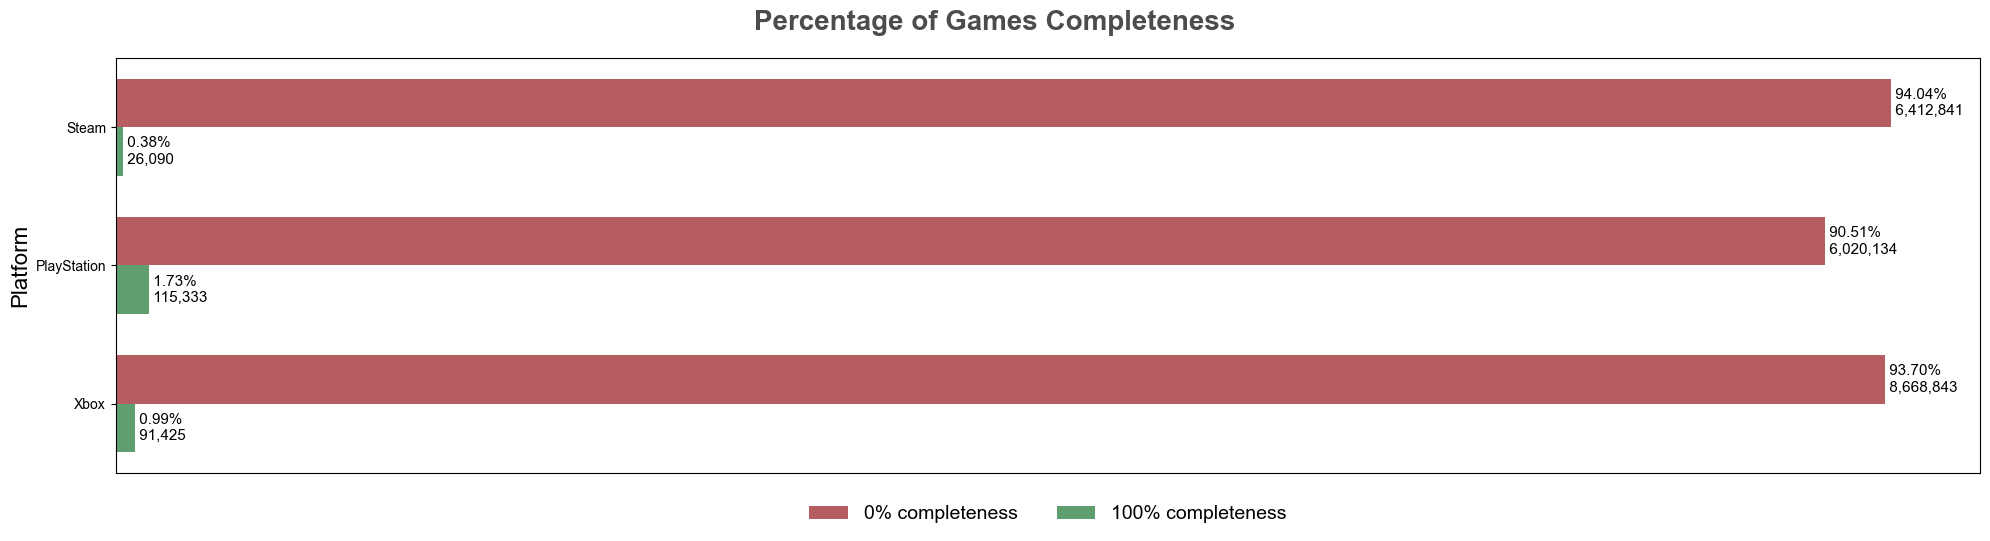

In [27]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(20, 5))
ax = sns.barplot(
    data=all_completion,
    x='ratio',
    y='platform',
    hue='percent',
    palette=['#c44e52', '#55a868'],
    width=.7
)

for container, (percent, sub_df) in zip(ax.containers, all_completion.groupby('percent')):
    labels = [f' {r:.2f}%\n {q:,}' for r, q in zip(sub_df['ratio'], sub_df['quantity'])]
    ax.bar_label(container, labels=labels, fontsize=11)

plt.xlabel('')
plt.xticks([])
plt.ylabel('Platform', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
labels = [f'{label}% completeness' for label in labels]
plt.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(.5, -.1), ncol=2, frameon=False, fontsize=14)

fig.text(.5, 1.04, 'Percentage of Games Completeness',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

##### ***Unexpected results. Nearly 90% of purchased games on each platform are never even launched***  

**Cases when this is good or bad:**  
* For game developers with **in-game monetization**, this could **be a problem**, as it’s important for players to engage regularly and purchase in-game items  
* For companies that periodically release games, this **should be addressed**, as if a person bought a game but never launched it,  
it could indicate they didn’t like it or that the technical system requirements are too high. This may result in the **user ignoring future releases of the game**
* **In other cases**, it may not be as important whether the player actually plays the game. People purchase games but don't launch them, and the **profit is still there**

## **User Solvency Analysis**

> **Note:** Further analysis will be conducted considering the constraints of the data and specific conditions  
* User **currency** is determined based on the **country** specified in **their profile**  
* Activity is assessed only for **games that have achievements**  
* Game price is determined by the **average value** over the data collection period
* **Purchase date** is defined by the date of **first achievement obtained** in the game


In [28]:
# Cell execution time ~1m 49.8s

# First and last achievement dates per year for each game
activity = {}
for platform in PLATFORMS:
    activity[platform] = pd.read_csv(f'resources/activity_{platform}.csv', parse_dates=['date_min', 'date_max'])
    activity[platform] = (
        activity[platform]
        .groupby(['playerid', 'gameid'], as_index=False)
        .agg({'date_min': min, 'date_max': max})
        .rename(columns={'date_min': 'first_activity', 'date_max': 'last_activity'})
    )

We will remove only irrelevant games, but keep users who engaged in manipulations since only revenue matters in this section

In [29]:
for platform in PLATFORMS:
    activity[platform] = activity[platform].query('gameid in @gameids[@platform]')

activity[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55


### **Analyze purchases by region, year, and genre**

#### **All purchases**

In [30]:
purchased = {}
for platform in PLATFORMS:
    purchased[platform] = (
        postgres_data(platform, 'purchased_games')
        .dropna()
        .explode('library')
        .query('library in @gameids[@platform]')
        .groupby('playerid', as_index=False)
        .library
        .size()
        .rename(columns={'size': 'purchased'})
    )

purchased[PLATFORMS[0]].head(3)

,playerid,purchased
0,76561197960270682,472
1,76561197960272112,2122
2,76561197960272169,2195


Determine the **proportion of users** who have **more than 2000 purchased** games in their library

In [31]:
for platform in PLATFORMS:
    label = platform.capitalize().replace('s', 'S')
    ratio = purchased[platform].query("purchased > 2000").shape[0] / purchased[platform].shape[0]
    print(f'{label}: % of values greater than 2000 out of the total - {(ratio * 100):.2f}%')

Steam: % of values greater than 2000 out of the total - 1.49%
PlayStation: % of values greater than 2000 out of the total - 0.06%
Xbox: % of values greater than 2000 out of the total - 0.74%


The percentage of such players is quite small to include in the sample, as they are **likely loyal to various genres/publishers** and *tend to purchase a large number of games*

The disparity between platforms is immediately visible. Let's try removing outliers and applying a logarithmic transformation (**The source data resembles a lognormal distribution**)

In [32]:
for platform in PLATFORMS:
    purchased[platform] = purchased[platform].query('purchased <= 2000')
    purchased[platform]['log_purchased'] = np.log(purchased[platform].purchased)

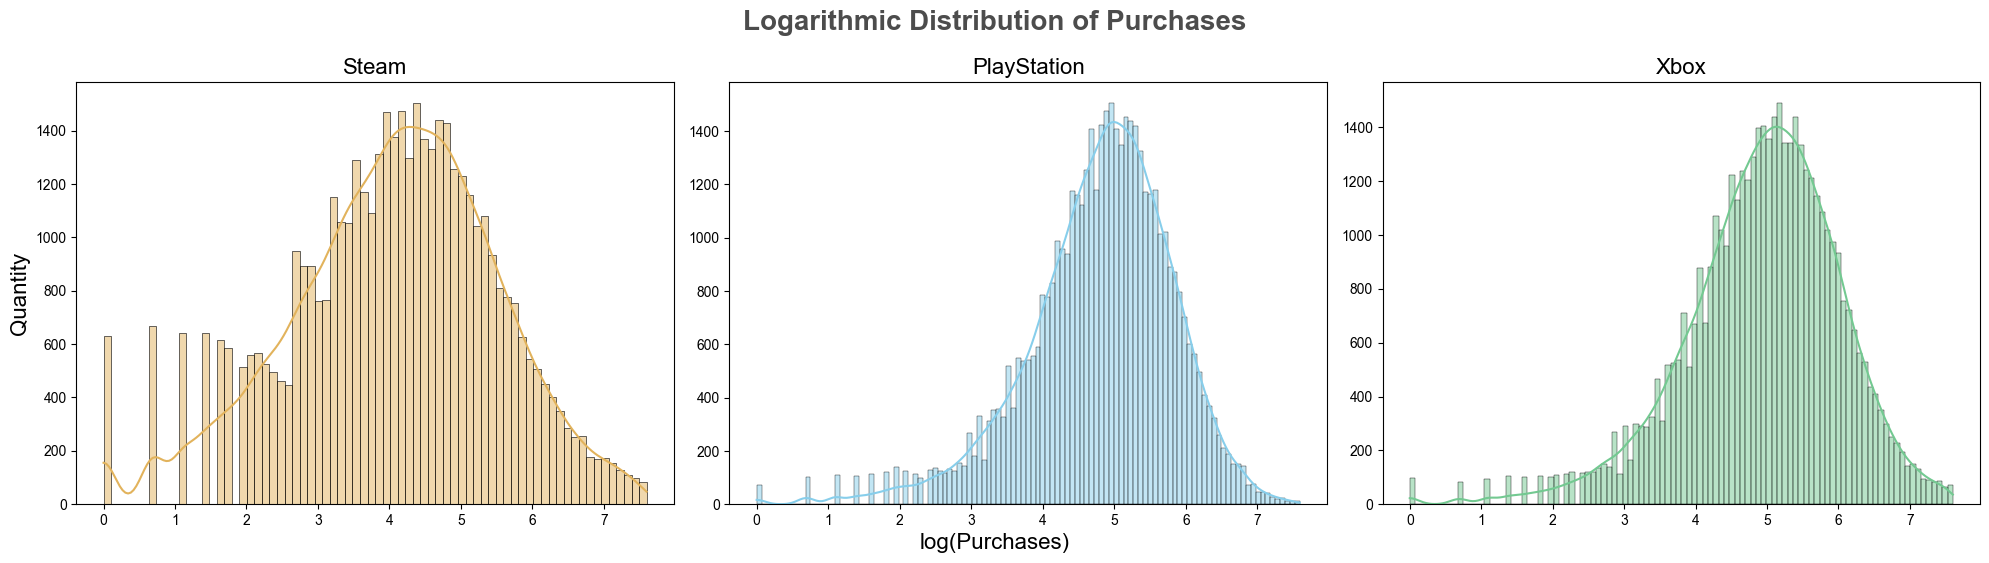

In [33]:
plt.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, color, platform in zip(axes, COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    sns.histplot(purchased[platform].log_purchased, kde=True, ax=ax, color=color)

    ax.set_title(label, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[0].set_ylabel('Quantity', fontsize=16)
fig.text(.5, 0, 'log(Purchases)',
         ha='center', va='center', fontsize=16)

fig.text(.5, 1.04, 'Logarithmic Distribution of Purchases',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

The logarithmic transformation did not normalize any distribution, so we will use non-parametric tests to assess differences

> **Kruskal-Wallis Test and Dunn's Test with Holm's Correction**

In [34]:
samples = [purchased[platform].purchased for platform in PLATFORMS]

statistic, pvalue = stats.kruskal(samples[0], samples[1], samples[2])
if pvalue < ALPHA:
    print(f'Kruskal-Wallis Test\n' \
          f'Statistical significance was found — There are differences between the groups\n' \
          f'Statistic: {statistic:.2f}  | Probability: {pvalue:.2f}  | Significance level: {ALPHA}')
else:
    print(f'Kruskal-Wallis Test\n' \
          f'No statistical significance was found — No differences were found between the groups\n' \
          f'Statistic: {statistic:.2f}  | Probability: {pvalue:.2f}  | Significance level: {ALPHA}')

Kruskal-Wallis Test
Statistical significance was found — There are differences between the groups
Statistic: 11922.88  | Probability: 0.00  | Significance level: 0.05


In [35]:
print('Dunn`s Test with Holm`s Correction:')
print(posthoc_dunn(samples, p_adjust='holm'),'\n')
print('(1) - Steam;  (2) - PlayStation;  (3) - Xbox')

Dunn`s Test with Holm`s Correction:
     1             2             3
1  1.0  0.000000e+00  0.000000e+00
2  0.0  1.000000e+00  3.835350e-65
3  0.0  3.835350e-65  1.000000e+00 

(1) - Steam;  (2) - PlayStation;  (3) - Xbox


Each group is statistically significantly different from the others. Let's examine the average ranks of platforms

In [36]:
avg_rank = pd.DataFrame({
    'platform': ['Steam'] * len(samples[0]) + ['PlayStation'] * len(samples[1]) + ['Xbox'] * len(samples[2]),
    'purchased': np.concatenate([samples[0], samples[1], samples[2]])
})
avg_rank['rank'] = stats.rankdata(avg_rank.purchased)

mean_ranks = avg_rank.groupby('platform')['rank'].mean().sort_values(ascending=False)
print(mean_ranks)

platform
Xbox           79882.799980
PlayStation    75392.891896
Steam          53008.239374
Name: rank, dtype: float64


#### **Purchases by year**

> **Note:** This section considers only data with at least minimal activity (obtaining a single achievement).  
Determining the **purchase date** of a game that has never been launched is **not possible**

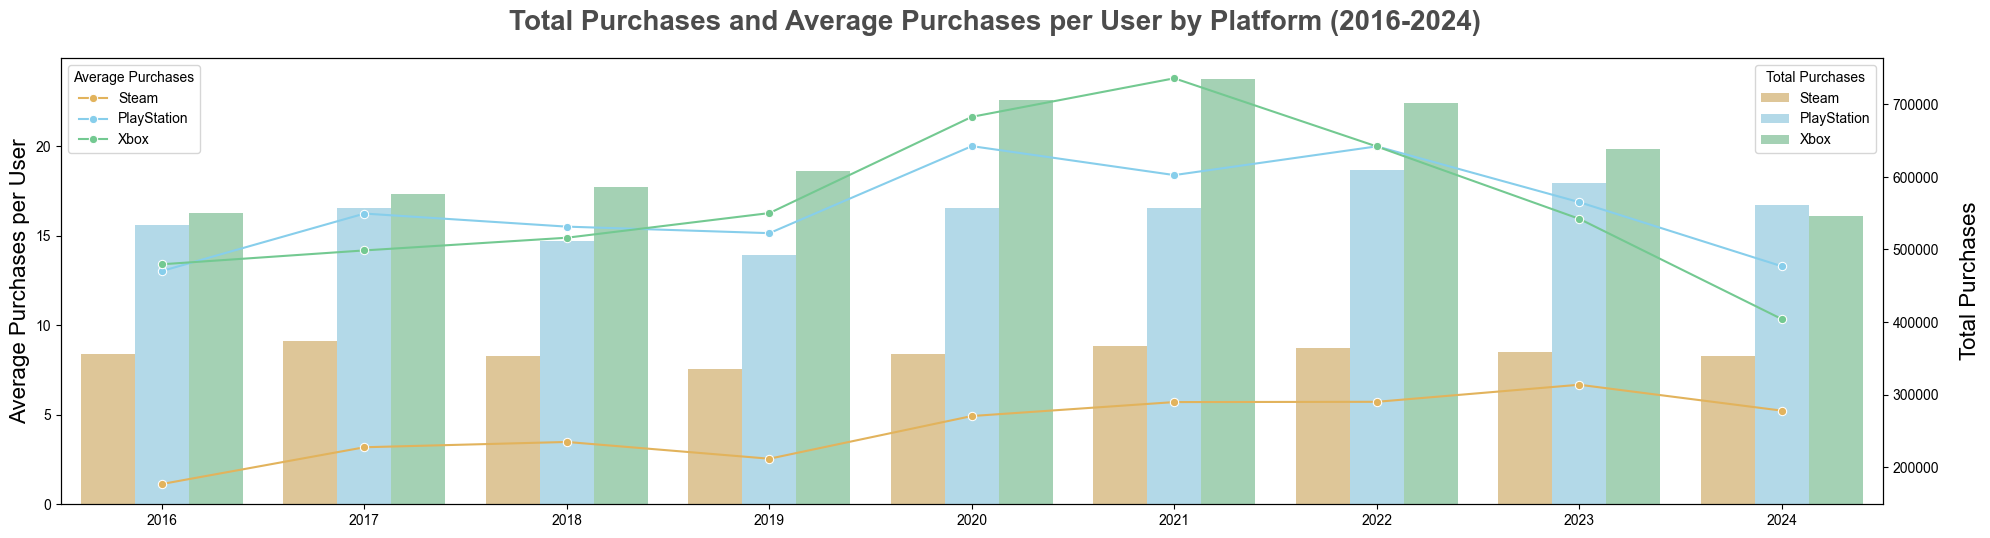

In [37]:
plt.rcParams['font.family'] = 'Arial'
fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

barplot_avg_year = pd.DataFrame()
for color, platform in zip(COLORS, PLATFORMS):
    label = platform.capitalize().replace('s', 'S')

    per_year = activity[platform]
    per_year['year'] = per_year.first_activity.dt.year

    total_per_year = (
        per_year
        .year
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
        .query('year > 2015')
        .sort_values('year')
        .reset_index(drop=True)
    )

    avg_per_year = (
        per_year
        .groupby(['playerid', 'year'], as_index=False)
        .agg({'gameid': 'count'})
        .groupby('year', as_index=False)
        .agg({'gameid': np.mean})
        .rename(columns={'gameid': 'avg_purchase'})
        .query('year > 2015')
    )
    avg_per_year['platform'] = label

    barplot_avg_year = pd.concat([barplot_avg_year, avg_per_year])

    sns.lineplot(data=total_per_year.quantity,
                 marker='o', ax=ax2, sort=False, color=color, label=label)
    
sns.barplot(x=barplot_avg_year.year,
            y=barplot_avg_year.avg_purchase,
            hue=barplot_avg_year.platform,
            alpha=.7, ax=ax1, palette=COLORS)

ax2.get_legend().remove()
ax1.legend(title='Total Purchases', loc='upper right')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=labels, title='Average Purchases', loc='upper left')

ax1.set_xlabel('')
ax1.set_ylabel('Average Purchases per User', fontsize=16)
ax2.set_ylabel('Total Purchases', fontsize=16, labelpad=15)

fig.text(.5, 1.04, 'Total Purchases and Average Purchases per User by Platform (2016-2024)',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

#### **Purchases by region**

> **Note:** This section considers only data with at least minimal activity (obtaining a single achievement).  
Determining the **purchase date** of a game that has never been launched is **not possible**

In [38]:
def _formatted_country(country: Optional[str]) -> Optional[str]:
    if country:
        return country.split(',')[0]
    return None

In [39]:
by_region = {}
for platform in PLATFORMS[:2]:
    players = postgres_data(platform, 'players')[['playerid', 'country']]
    
    if platform == 'steam':
        activity[platform].playerid = activity[platform].playerid.astype(str)

    by_region[platform] = activity[platform].merge(players, how='left')

    by_region[platform].country = by_region[platform].country.apply(_formatted_country)
    by_region[platform]['region'] = by_region[platform].country.apply(assign_region)
    by_region[platform]['quarter'] = by_region[platform].first_activity.dt.to_period('Q').astype(str)

by_region[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,year,country,region,quarter
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,2020,Switzerland,Europe,2020Q1
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,2018,Switzerland,Europe,2018Q1
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,2018,Switzerland,Europe,2018Q2


In [40]:
purchases_region = {}
for platform in PLATFORMS[:2]:
    purchases_region[platform] = (
        by_region[platform]
        .groupby(['region', 'quarter'], as_index=False)
        .agg({'gameid': 'count'})
        .rename(columns={'gameid': 'purchased'})
        .sort_values(['region', 'quarter'])
    )

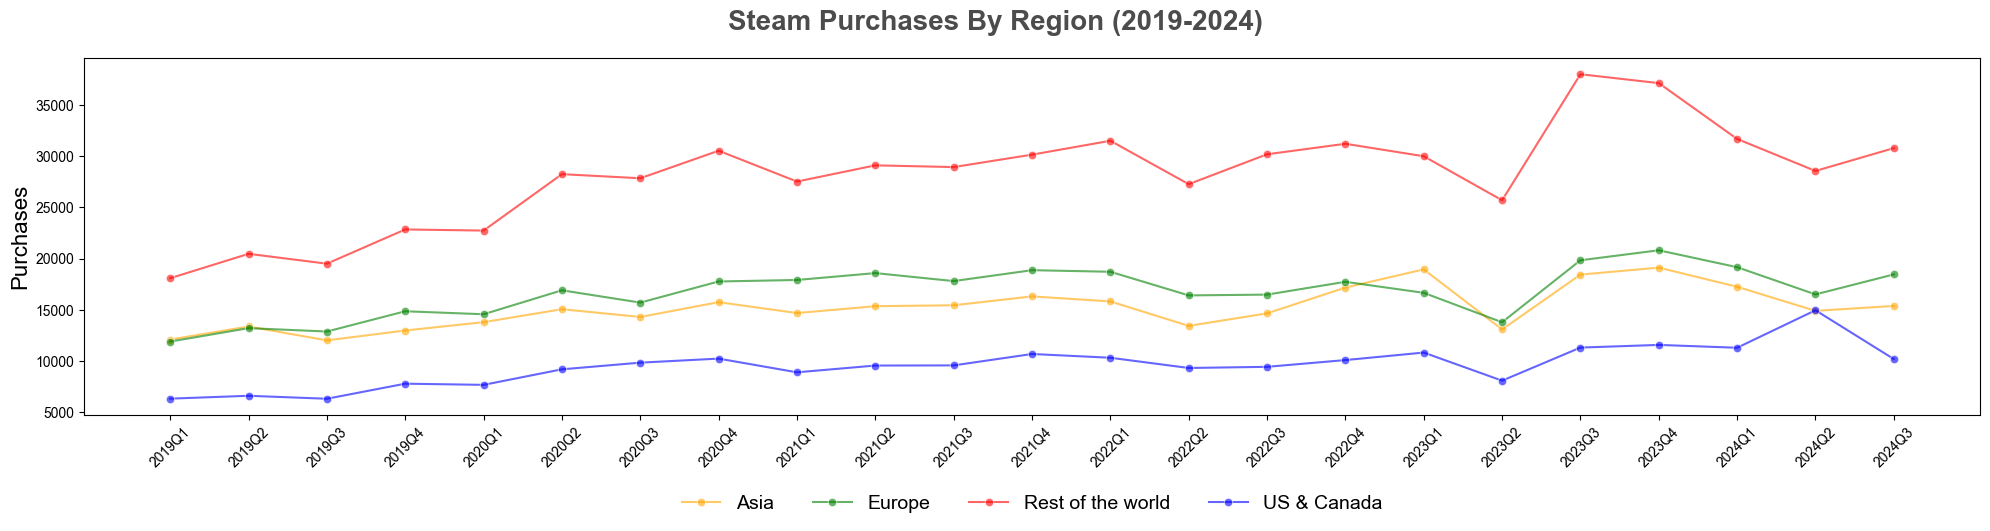

In [41]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(20, 5))

sns.lineplot(x='quarter', y='purchased', data=purchases_region[PLATFORMS[0]].query('"2018Q4" < quarter < "2024Q4"'), 
             hue='region', palette=['orange', 'green', 'red', 'blue'], marker='o', alpha=.6)

plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Purchases', fontsize=16)

plt.legend(loc='center', bbox_to_anchor=(.5, -.25), ncol=4, frameon=False, fontsize=14)

fig.text(.5, 1.04, 'Steam Purchases By Region (2019-2024)',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

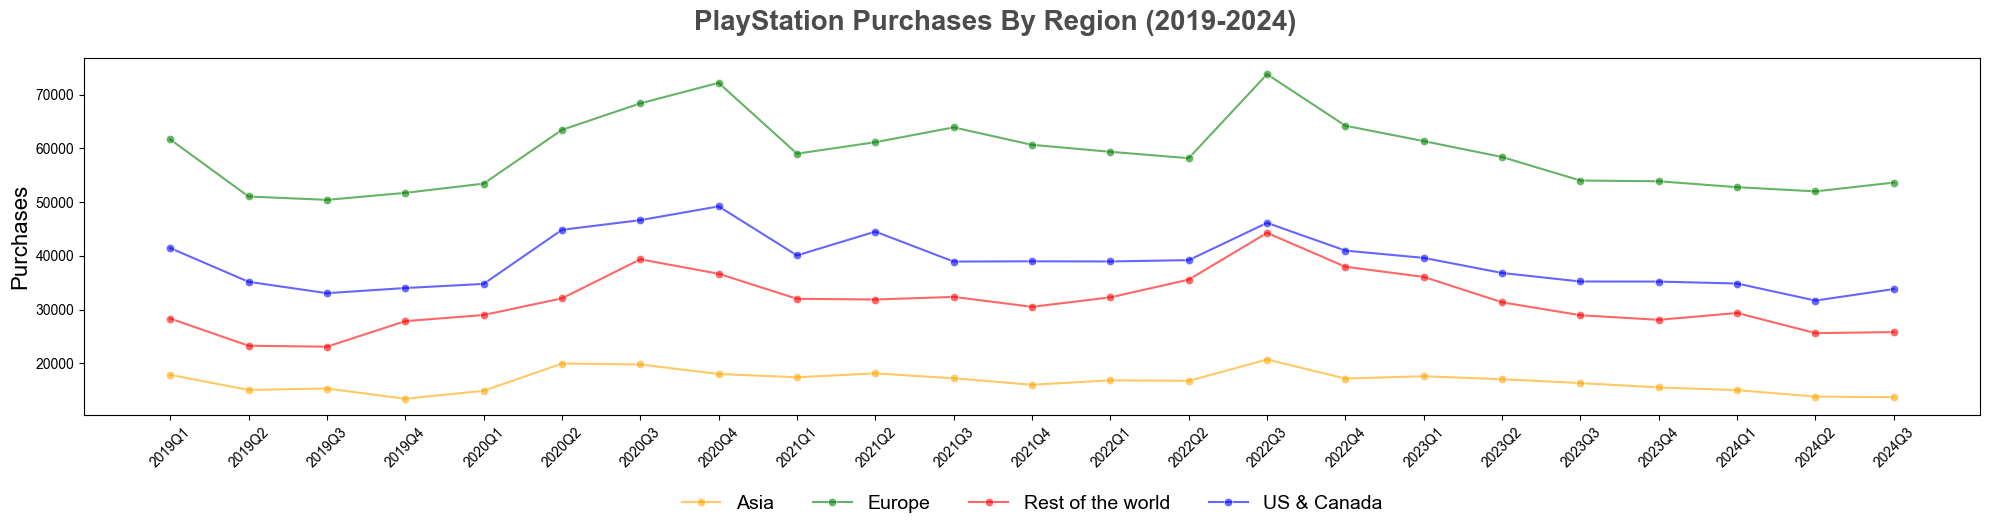

In [42]:
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(20, 5))

sns.lineplot(x='quarter', y='purchased', data=purchases_region[PLATFORMS[1]].query('"2018Q4" < quarter < "2024Q4"'), 
             hue='region', palette=['orange', 'green', 'red', 'blue'], marker='o', alpha=.6)

plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Purchases', fontsize=16)

plt.legend(loc='center', bbox_to_anchor=(.5, -.25), ncol=4, frameon=False, fontsize=14)

fig.text(.5, 1.04, 'PlayStation Purchases By Region (2019-2024)',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.tight_layout()

#### **Purchases by genres**

> **Note:** This section considers only data with at least minimal activity (obtaining a single achievement).  
Determining the **purchase date** of a game that has never been launched is **not possible**

In [43]:
games = {}
for platform in PLATFORMS:
    games[platform] = postgres_data(platform, 'games')
    games[platform] = games[platform].query('gameid in @gameids[@platform]')

In [44]:
# Cell execution time ~3m 56.6s

all_platforms = pd.DataFrame()
for platform in PLATFORMS:
    genres = activity[platform].merge(games[platform], how='left')[['first_activity', 'genres']]
    genres['year'] = genres.first_activity.dt.year

    genres = genres.explode('genres')
    
    genres.genres = genres.genres.apply(format_genre)
    genres = genres[genres.genres.isin(GENRES)]

    genres = (
        genres.genres
        .value_counts()
        .reset_index()
        .rename(columns={'count': 'quantity'})
    )
    
    all_platforms = pd.concat([all_platforms, genres.assign(platform=platform.capitalize())])

pivoted_frequency = (
    all_platforms
    .pivot(index='genres', columns='platform', values='quantity')
    .fillna(.0)
    .sort_values(['Steam', 'Playstation', 'Xbox'], ascending=False)
)

pivoted_frequency.head(3)

platform,Playstation,Steam,Xbox
genres,,,
Action,1832604.0,1706216.0,4298078.0
Indie,359737.0,1334050.0,351768.0
Adventure,1172675.0,1082596.0,2908256.0


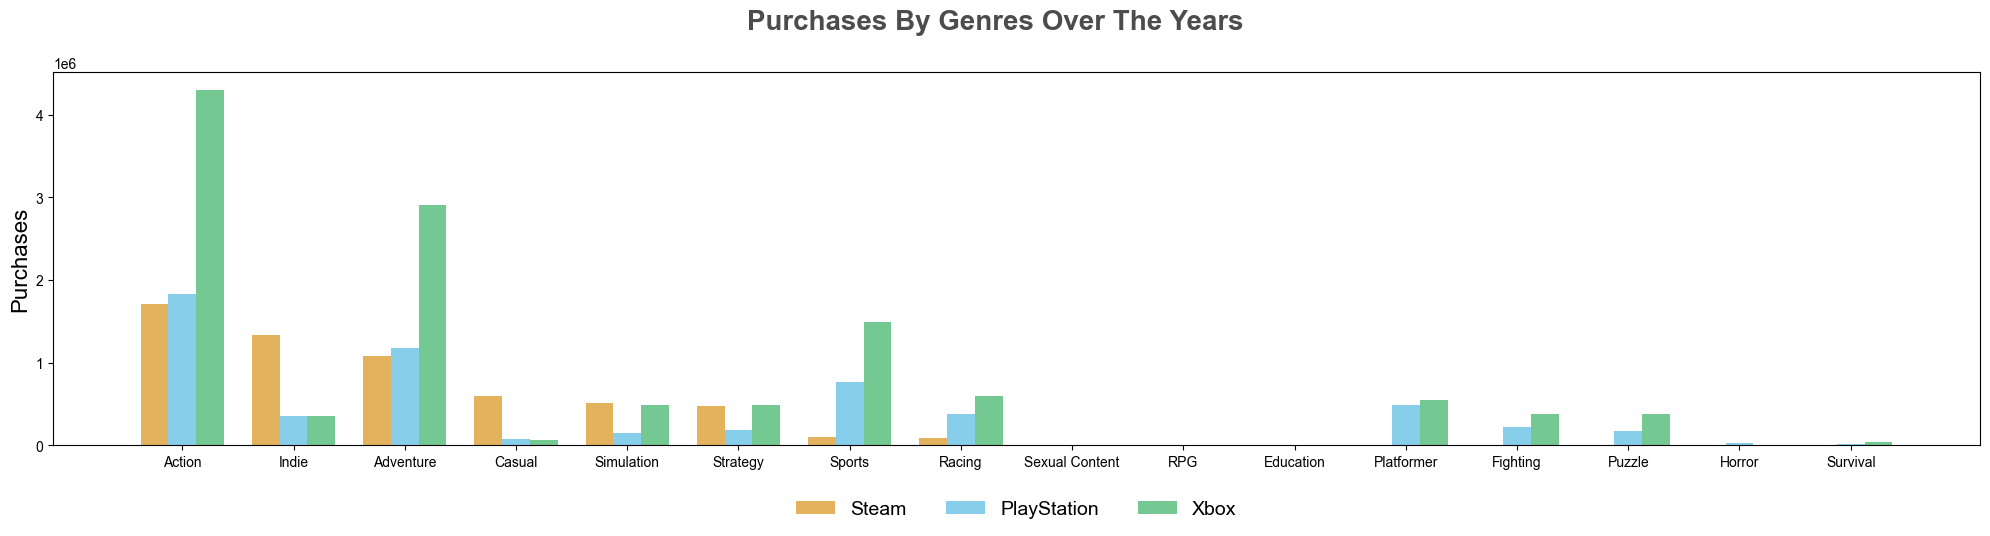

In [45]:
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(20, 5))

bar_width = .25
x = np.arange(len(pivoted_frequency))

for i, (color, platform) in enumerate(zip(COLORS, PLATFORMS)):
    platform = platform.capitalize()

    ax.bar(x + i * bar_width, pivoted_frequency[platform], bar_width,
           label=platform.replace('s', 'S'), color=color)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivoted_frequency.index)

ax.set_ylabel('Purchases', fontsize=16)

fig.text(.5, 1.04, 'Purchases By Genres Over The Years',
         ha='center', va='center', fontsize=20, weight='bold', alpha=.7)

plt.legend(loc='upper center', bbox_to_anchor=(.5, -.1), ncol=3, frameon=False, fontsize=14)

plt.tight_layout()

> **Note:** If we look at how the genre trends changed year by year for each platform, the leading genre is always `Action`

**Business Recommendations:**  
* For indie developers, `Steam` is the optimal entry point due to its low barrier to entry. For large-scale projects with substantial budgets, `Xbox` and `PlayStation` are preferable due to their higher purchasing power  
* No significant growth in game sales has been observed, indicating market stabilization and increased competition.  
To achieve differentiation, developers should prioritize product quality, marketing strategies, and unique game mechanics  
* When selecting a platform, focus on the most active regions: `PlayStation` performs best in `Europe`, while `Steam` maintains stable sales across `all regions` except the `US & Canada`  
* High-demand, `cross-platform` genres include `Action` and `Adventure`. Additionally, `Indie` games perform well on `Steam`,  
while `Sports, Platformer` games are more popular on `Xbox` and `PlayStation`. Avoid investing in low-demand genres unless there is a clear understanding of the target audience  
* For developers with **budget constraints**, launching on `Steam` minimizes costs. **Console** releases require **additional investment** in certification and marketing

### **Metrics ARPU, LTV**

#### **Average Revenue per User**

The specified restrictions mentioned at the beginning of the `User Solvency Analysis` section are applied  
Currently, the process of parsing game price data for PlayStation and Xbox is not implemented (**analysis for these platforms will be added soon**)

Calculating the ARPU metric in this case is a complex task. It is important to consider that each country has a different average income level.  
The price of a game may be localized for each market. The unstable exchange rate on each purchase date also needs to be accounted for

**General idea:** Determine the user's purchase currency based on their country. Convert the data to a single currency (USD) and normalize ARPU by the country's GDP per capita

$$Adjusted~ARPU=\frac{ARPU~(USD)}{GDP~per~capita~(USD)}$$

In [46]:
for platform in PLATFORMS[:1]:
    activity[platform].playerid = activity[platform].playerid.astype(str)
    activity[platform] = activity[platform].merge(postgres_data(platform, 'players'), how='left')

activity[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,year,country,created
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,2020,Switzerland,2003-09-12 11:46:36
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,2018,Switzerland,2003-09-12 11:46:36
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,2018,Switzerland,2003-09-12 11:46:36


Since the data is limited (**5 currencies in the database**), we will implement a simple, **approximate determination** of the currency based on the user's country:

In [47]:
for platform in PLATFORMS[:1]:
    activity[platform]['currency'] = activity[platform].country.apply(define_currency)

activity[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,year,country,created,currency
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,2020,Switzerland,2003-09-12 11:46:36,USD
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,2018,Switzerland,2003-09-12 11:46:36,USD
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,2018,Switzerland,2003-09-12 11:46:36,USD


The game price is determined by the **average price** over the entire data collection period

In [48]:
prices = {}
for platform in PLATFORMS[:1]:
    prices[platform] = (
        postgres_data(platform, 'prices')
        .groupby('gameid', as_index=False)
        .agg({'usd': np.mean, 'eur': np.mean, 'gbp': np.mean, 'jpy': np.mean, 'rub': np.mean})
    )

In [49]:
merged_activity = {}
for platform in PLATFORMS[:1]:
    merged_activity[platform] = activity[platform].merge(prices[platform], how='left')

merged_activity[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,year,country,created,currency,usd,eur,gbp,jpy,rub
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,2020,Switzerland,2003-09-12 11:46:36,USD,7.545556,7.366667,6.422222,906.666667,290.888889
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,2018,Switzerland,2003-09-12 11:46:36,USD,7.545556,7.366667,6.422222,906.666667,290.888889
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,2018,Switzerland,2003-09-12 11:46:36,USD,7.545556,7.366667,6.422222,906.666667,290.888889


Determine the player's currency based on their specified country. If the country is not specified, the **default currency USD** is used

In [50]:
def _get_price(row):
    currency = row['currency'].lower()
    return row[currency]

In [51]:
for platform in PLATFORMS[:1]:
    merged_activity[platform]['price_local'] = merged_activity[platform].apply(_get_price, axis=1)

    merged_activity[platform] = (
        merged_activity[platform]
        [['playerid', 'gameid', 'first_activity',
        'last_activity', 'country', 'currency', 'price_local']]
    )

merged_activity[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,country,currency,price_local
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,Switzerland,USD,7.545556
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,Switzerland,USD,7.545556
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,Switzerland,USD,7.545556


In [52]:
currency_converter = CurrencyConverter()

def _convert_to_usd(row):
    # Process users with the default currency
    if row.currency == 'USD':
        return row.price_local

    # Purchase date
    date_obj = row.first_activity
    # Historical exchange rate data for RUB is limited.
    # If the data is later than 2022-03-01, the last available value is used as the current rate
    if row['currency'] == 'RUB':
        date_obj = min(date_obj, pd.to_datetime('2022-03-01'))

    # `days_to_substract` - the number of days to subtract from the purchase date
    # to find an approximate exchange rate, if it is missing in `currency_converter`
    days_to_subtract = 0
    while True:
        try:
            return currency_converter.convert(row.price_local,
                                              row.currency, 'USD',
                                              date=date_obj - timedelta(days=days_to_subtract))
        except RateNotFoundError:
            days_to_subtract += 1

            if days_to_subtract > 30:
                return None

In [53]:
# Cell execution time ~2m 42.6s

for platform in PLATFORMS[:1]:
    merged_activity[platform]['price_usd'] = merged_activity[platform].apply(_convert_to_usd, axis=1)

merged_activity[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,country,currency,price_local,price_usd
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,Switzerland,USD,7.545556,7.545556
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,Switzerland,USD,7.545556,7.545556
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,Switzerland,USD,7.545556,7.545556


Check for missing values

In [54]:
def _check_nan():
    for platform in PLATFORMS[:1]:
        nans = merged_activity[platform].price_usd.isna().sum()
        total = merged_activity[platform].shape[0]

        label = platform.capitalize().replace('s', 'S')
        
        print(f'{label}: Missing {nans} out of {total} ({nans / total * 100:.2f}%)')

In [55]:
_check_nan()

Steam: Missing 619092 out of 2677325 (23.12%)


In [56]:
merged_activity[PLATFORMS[0]][merged_activity[PLATFORMS[0]].price_usd.isna()].head(3)

,playerid,gameid,first_activity,last_activity,country,currency,price_local,price_usd
3,76561197960270682,730,2023-10-02 21:39:33,2023-10-02 21:39:33,Switzerland,USD,NaN,NaN
8,76561197960270682,203770,2019-10-24 05:20:29,2019-10-24 05:20:29,Switzerland,USD,NaN,NaN
15,76561197960270682,238960,2017-11-09 22:00:15,2017-11-17 10:14:22,Switzerland,USD,NaN,NaN


Most of the **missing values** are from **Free-To-Play** games. We will remove these missing values

In [57]:
for platform in PLATFORMS[:1]:
    merged_activity[platform] = (
        merged_activity[platform]
        .dropna(subset=['price_local', 'price_usd'])
        .reset_index(drop=True)
    )

##### **GDP per capita**

> **Data sourced from [World Bank Group](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)**  

Retrieve **GDP per capita** for each country and **normalize** `price_usd` values

In [58]:
gdp_per_capita = pd.read_csv('resources/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_62.csv')[['Country Name', '2023']]
gdp_per_capita.columns = ['country', 'gdp_per_capita']
gdp_per_capita.head(3)

,country,gdp_per_capita
0,Aruba,33984.790620
1,Africa Eastern and Southern,1659.515290
2,Afghanistan,415.707417


In [59]:
all_data = {}
for platform in PLATFORMS[:1]:
    merged_activity[platform].country = merged_activity[platform].country.apply(_formatted_country)
    all_data[platform] = merged_activity[platform].merge(gdp_per_capita, how='left')
    all_data[platform]['price_adjusted'] = all_data[platform].price_usd / all_data[platform].gdp_per_capita

all_data[PLATFORMS[0]].head(3)

,playerid,gameid,first_activity,last_activity,country,currency,price_local,price_usd,gdp_per_capita,price_adjusted
0,76561197960270682,220,2020-01-19 19:27:05,2020-01-20 02:43:12,Switzerland,USD,7.545556,7.545556,99564.710026,0.000076
1,76561197960270682,240,2018-03-17 14:22:14,2022-12-26 20:43:35,Switzerland,USD,7.545556,7.545556,99564.710026,0.000076
2,76561197960270682,620,2018-04-05 20:43:51,2018-08-07 00:49:55,Switzerland,USD,7.545556,7.545556,99564.710026,0.000076


***The task of determining missing GDP for unspecified countries of residence and for countries where no data was found remains open***  

In [60]:
for platform in PLATFORMS[:1]:
    all_data[platform]['region'] = all_data[platform].country.apply(assign_region)
    all_data[platform]['quarter'] = all_data[platform].first_activity.dt.to_period('Q').astype(str)

    all_data[platform] = all_data[platform][['playerid', 'price_usd', 'price_adjusted', 'region', 'quarter']]

all_data[PLATFORMS[0]].head(3)

,playerid,price_usd,price_adjusted,region,quarter
0,76561197960270682,7.545556,0.000076,Europe,2020Q1
1,76561197960270682,7.545556,0.000076,Europe,2018Q1
2,76561197960270682,7.545556,0.000076,Europe,2018Q2


In [61]:
arpu = (
    all_data[PLATFORMS[0]]
    .groupby(['region', 'quarter'], as_index=False)
    .agg({'playerid': pd.Series.nunique, 'price_usd': sum, 'price_adjusted': sum})
    .rename(columns={'playerid': 'users', 'price_usd': 'revenue', 'price_adjusted': 'revenue_adjusted'})
)

arpu['arpu'] = arpu.revenue / arpu.users
arpu['adjusted_arpu'] = arpu.revenue_adjusted / arpu.users
arpu = arpu.sort_values('quarter')

arpu.head(3)

,region,quarter,users,revenue,revenue_adjusted,arpu,adjusted_arpu
131,Rest of the world,2008Q3,4,30.182222,0.000116,7.545556,0.000029
65,Europe,2008Q3,2,23.785422,0.000481,11.892711,0.000240
0,Asia,2008Q4,4,35.495714,0.020226,8.873929,0.005057


In [62]:
world_wide_arpu = (
    all_data[PLATFORMS[0]]
    .groupby('quarter', as_index=False)
    .agg({'playerid': pd.Series.nunique, 'price_usd': sum, 'price_adjusted': sum})
    .rename(columns={'playerid': 'users', 'price_usd': 'revenue', 'price_adjusted': 'adjusted_revenue'})
)

world_wide_arpu['arpu'] = world_wide_arpu.revenue / world_wide_arpu.users
world_wide_arpu['adjusted_arpu'] = world_wide_arpu.adjusted_revenue / world_wide_arpu.users

world_wide_arpu.head(3)

,quarter,users,revenue,adjusted_revenue,arpu,adjusted_arpu
0,2008Q3,6,53.967645,0.000597,8.994607,0.000100
1,2008Q4,39,340.944783,0.024381,8.742174,0.000625
2,2009Q1,68,847.604569,0.016214,12.464773,0.000238


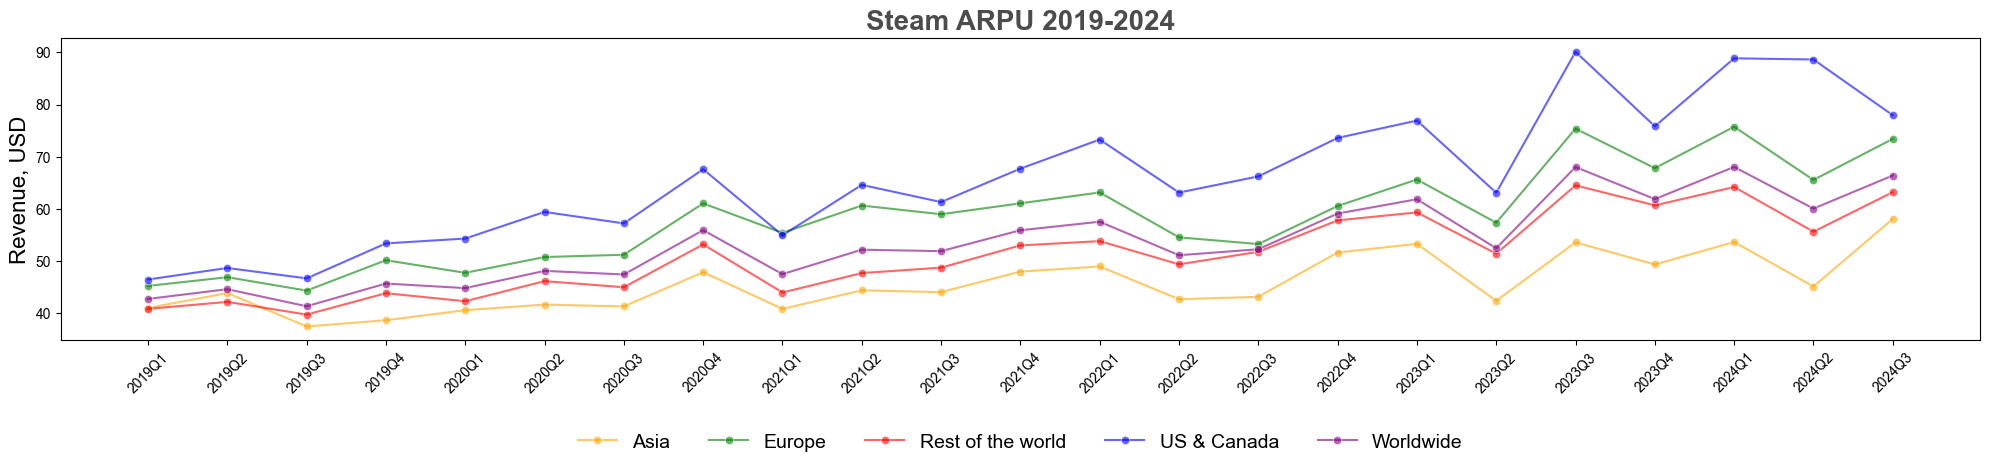

In [63]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(20, 5))

arpu = arpu.sort_values(['region', 'quarter'])

sns.lineplot(x='quarter', y='arpu', data=arpu.query('"2018Q4" < quarter < "2024Q4"'), 
             hue='region', marker='o', palette=['orange', 'green', 'red', 'blue'], alpha=.6)
sns.lineplot(x='quarter', y='arpu', data=world_wide_arpu.query('"2018Q4" < quarter < "2024Q4"'),
             label='Worldwide', marker='o', color='purple', alpha=.6)

plt.xticks(rotation=45)
plt.xlabel('')
plt.xlabel('')
plt.ylabel('Revenue, USD', fontsize=16)

plt.legend(loc='upper center', bbox_to_anchor=(.5, -.25), ncol=5, frameon=False, fontsize=14)

plt.title('Steam ARPU 2019-2024', fontsize=20, loc='center', weight='bold', alpha=.7)

plt.tight_layout()

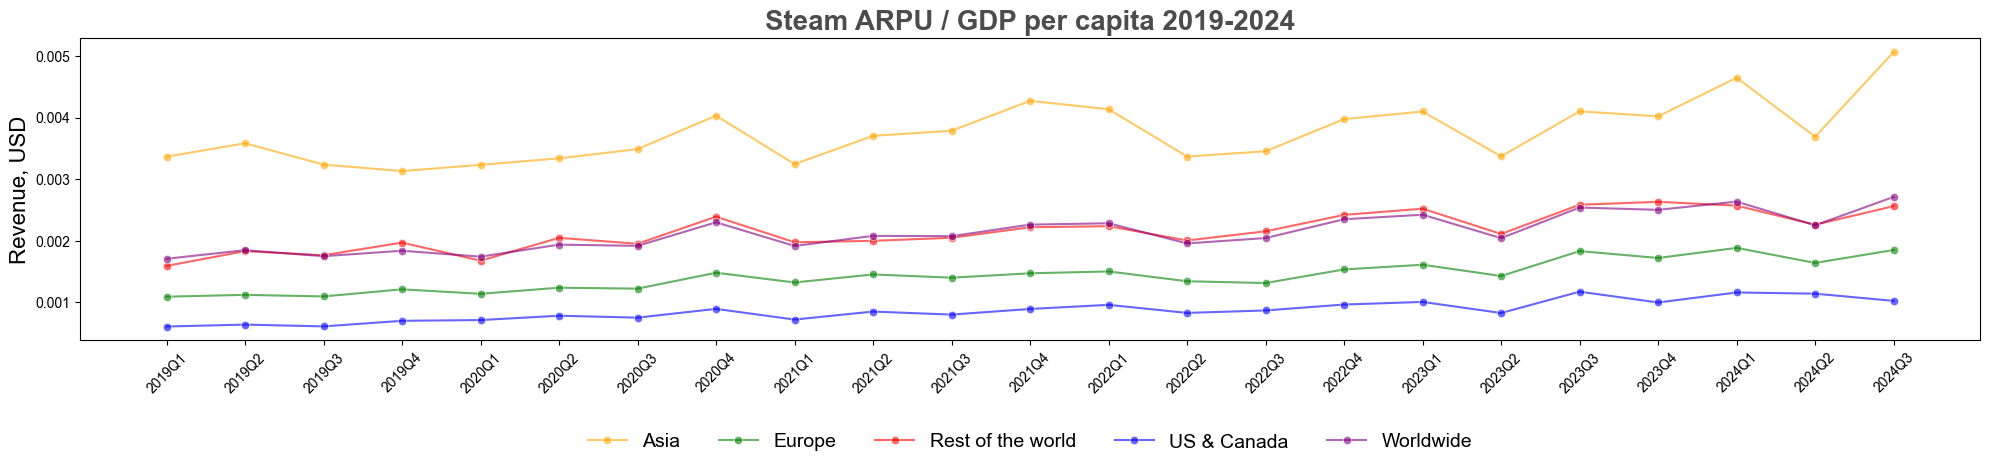

In [64]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(20, 5))

arpu = arpu.sort_values(['region', 'quarter'])

sns.lineplot(x='quarter', y='adjusted_arpu', data=arpu.query('"2018Q4" < quarter < "2024Q4"'),
             hue='region', marker='o', palette=['orange', 'green', 'red', 'blue'], alpha=.6)
sns.lineplot(x='quarter', y='adjusted_arpu', data=world_wide_arpu.query('"2018Q4" < quarter < "2024Q4"'),
             label='Worldwide', marker='o', color='purple', alpha=.6)

plt.xticks(rotation=45)
plt.xlabel('')
plt.xlabel('')
plt.ylabel('Revenue, USD', fontsize=16)

plt.legend(loc='upper center', bbox_to_anchor=(.5, -.25), ncol=5, frameon=False, fontsize=14)

plt.title('Steam ARPU / GDP per capita 2019-2024', fontsize=20, loc='center', weight='bold', alpha=.7)

plt.tight_layout()

#### **Customer Lifetime Value**

The formula used to calculate `LTV` will **not account** for the average user **retention**

$$LTV = \frac{Cumulative~Revenue}{Users}$$

> **Note:** A version considering user lifetime (Retention) will be proposed later

In [65]:
def _ltv(df):
    df = df.sort_values('quarter')

    cumulative_revenue = df.groupby('quarter', as_index=False).agg({'price_usd': sum})
    cumulative_revenue['cumsum_price'] = cumulative_revenue.price_usd.cumsum()
    
    users = defaultdict(int)
    quarters = cumulative_revenue.quarter.to_list()
    for i in range(len(quarters)):
        slice_quarters = quarters[:i + 1]
        unique_quarters = set(slice_quarters)
        
        users[slice_quarters[-1]] = df.query('quarter in @unique_quarters').playerid.nunique()

    return cumulative_revenue.merge(pd.DataFrame(data={'quarter': users.keys(), 'users': users.values()}), how='left')

In [66]:
ltv_df = _ltv(all_data[PLATFORMS[0]])
ltv_df['ltv'] = ltv_df.cumsum_price / ltv_df.users

ltv_df.head(3)

,quarter,price_usd,cumsum_price,users,ltv
0,2008Q3,53.967645,53.967645,6,8.994607
1,2008Q4,340.944783,394.912428,45,8.775832
2,2009Q1,847.604569,1242.516997,111,11.193847


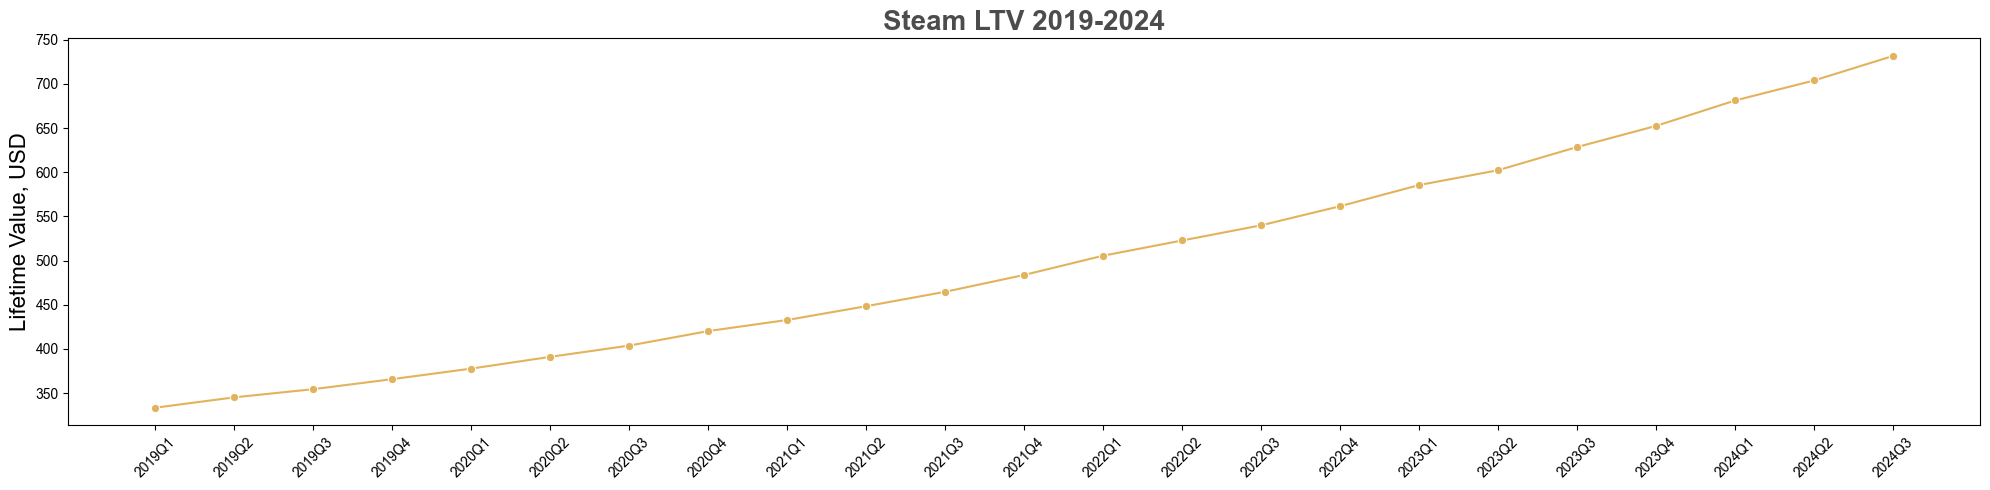

In [67]:
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(20, 5))

sns.lineplot(x='quarter', y='ltv', data=ltv_df.query('"2018Q4" < quarter < "2024Q4"'), marker='o', color=COLORS[0])

plt.xticks(rotation=45)
plt.xlabel('')
plt.xlabel('')
plt.ylabel('Lifetime Value, USD', fontsize=16)

plt.title('Steam LTV 2019-2024', fontsize=20, loc='center', weight='bold', alpha=.7)

plt.tight_layout()

**Business Recommendations:**  
* For the **US and European** markets, focus on **one-time** purchase games **with DLC**. For the **Asian** market, **Free-to-Play with microtransactions** is a better fit
* **Release** games during peak seasons (**fall and winter**), around **Q4**. Do not expect high demand in **Q1** - use this **period for updates, patches, and marketing**
* **Localize** the game into at **least English, Spanish, and Chinese**
* **Adapt pricing:** set affordable prices in **Asia** and other regions with **low ARPU**, or use the **F2P model**